In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
same_df = pd.read_csv('/content/drive/MyDrive/same_no_outlier-2.csv')
int_df = pd.read_csv('/content/drive/MyDrive/int_no_outlier-2.csv')

In [4]:
same_df['Covid19'] = same_df['Covid19'].apply(lambda x: 1 if x else 0)
int_df['Covid19'] = int_df['Covid19'].apply(lambda x: 1 if x else 0)

In [5]:
boolean_columns = [
    "Covid19",
    "US_President_Republican",
    "US_President_Democratic",
    "KR_President_Democratic",
    "KR_President_Conservative",
    "KR_President_Neutral"
]

same_df[boolean_columns] = same_df[boolean_columns].astype(bool)
int_df[boolean_columns] = int_df[boolean_columns].astype(bool)

In [6]:
same_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5862 entries, 0 to 5861
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       5862 non-null   object 
 1   Open                       5862 non-null   int64  
 2   High                       5862 non-null   int64  
 3   Low                        5862 non-null   int64  
 4   Close                      5862 non-null   int64  
 5   Volume                     5862 non-null   int64  
 6   Change                     5862 non-null   float64
 7   Transaction                5862 non-null   int64  
 8   SE_Operating_Profit        5862 non-null   float64
 9   SE_Net_Profit              5862 non-null   float64
 10  SE_Total_Equity            5862 non-null   float64
 11  SE_Total_Liabilities       5862 non-null   float64
 12  SE_Revenue                 5862 non-null   float64
 13  SE_Foreign                 5862 non-null   float

In [7]:
same_df.set_index('Date', inplace = True)
int_df.set_index('Date', inplace = True)

In [8]:
# same_df
train_same_df = same_df.iloc[:3519]
val_same_df = same_df.iloc[3519:4692]
test_same_df = same_df.iloc[4692:]

# int_df
train_int_df = int_df.iloc[:3519]
val_int_df = int_df.iloc[3519:4692]
test_int_df = int_df.iloc[4692:]

In [9]:
print(len(train_same_df), len(val_same_df), len(test_same_df))
print(len(train_int_df), len(val_int_df), len(test_int_df))

3519 1173 1170
3519 1173 1170


In [10]:
import numpy as np

def create_sequences(data, target, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])  # 시퀀스 데이터를 특성으로 사용
        y.append(target.iloc[i + seq_length])  # 예측할 목표값 (iloc 사용)
    return np.array(x), np.array(y)


seq_length = 30 #일단 30일

# 각 데이터셋을 sequence로 변환
x_train, y_train = create_sequences(train_same_df.drop(columns=['Close']), train_same_df['Close'], seq_length)
x_val, y_val = create_sequences(val_same_df.drop(columns=['Close']), val_same_df['Close'], seq_length)
x_test, y_test = create_sequences(test_same_df.drop(columns=['Close']), test_same_df['Close'], seq_length)

# 데이터 차원 변경 -> XGBoost는 2D 형태의 데이터 입력을 필요, (samples, features) 형태로 변환
x_train = x_train.reshape((x_train.shape[0], -1))  # (배치 크기, 특성 수) 형태로 변환
x_val = x_val.reshape((x_val.shape[0], -1))  # (배치 크기, 특성 수) 형태로 변환
x_test = x_test.reshape((x_test.shape[0], -1))  # (배치 크기, 특성 수) 형태로 변환


[0]	validation_0-rmse:5237.86671	validation_1-rmse:23064.74303
[1]	validation_0-rmse:3686.43611	validation_1-rmse:20211.37537
[2]	validation_0-rmse:2599.27398	validation_1-rmse:18296.55853
[3]	validation_0-rmse:1839.38511	validation_1-rmse:16951.72339
[4]	validation_0-rmse:1309.27268	validation_1-rmse:15956.89252
[5]	validation_0-rmse:940.86075	validation_1-rmse:15755.55984
[6]	validation_0-rmse:686.57515	validation_1-rmse:15604.01397
[7]	validation_0-rmse:512.12153	validation_1-rmse:15361.16118
[8]	validation_0-rmse:394.08756	validation_1-rmse:15128.53720
[9]	validation_0-rmse:316.12445	validation_1-rmse:15010.64489
[10]	validation_0-rmse:264.74627	validation_1-rmse:14940.85312
[11]	validation_0-rmse:231.65893	validation_1-rmse:14853.91240
[12]	validation_0-rmse:207.93126	validation_1-rmse:14820.00475
[13]	validation_0-rmse:193.75821	validation_1-rmse:14774.26206
[14]	validation_0-rmse:181.33411	validation_1-rmse:14768.16065
[15]	validation_0-rmse:172.08265	validation_1-rmse:14753.100

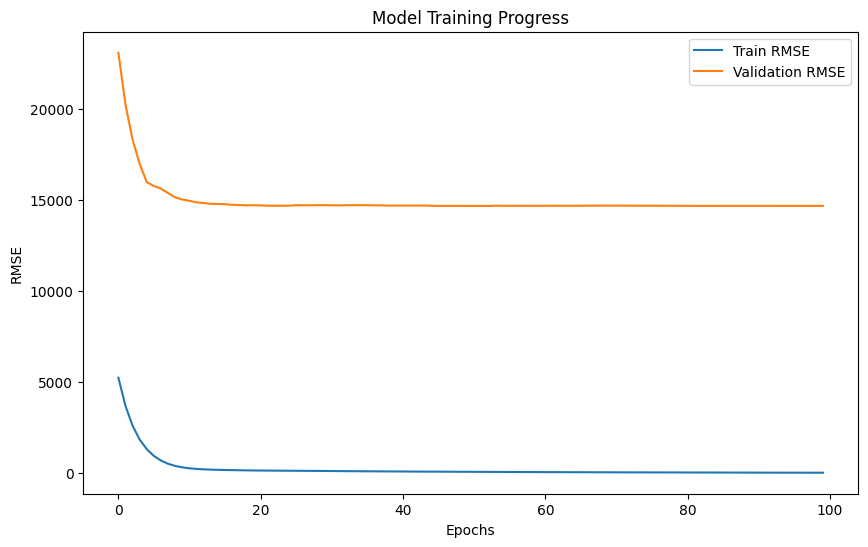

In [11]:
import matplotlib.pyplot as plt
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
evals = [(x_train, y_train), (x_val, y_val)]
evals_result = model.fit(x_train, y_train, eval_set=evals, verbose=True)
evals_result = model.evals_result()

epochs = len(evals_result['validation_0']['rmse'])  # 전체 훈련 에포크 수
x_axis = range(0, epochs)

plt.figure(figsize=(10,6))
plt.plot(x_axis, evals_result['validation_0']['rmse'], label='Train RMSE')
plt.plot(x_axis, evals_result['validation_1']['rmse'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Model Training Progress')
plt.legend()
plt.show()

[0]	validation_0-rmse:5237.86671	validation_1-rmse:23064.74303
[1]	validation_0-rmse:3686.43611	validation_1-rmse:20211.37537
[2]	validation_0-rmse:2599.27398	validation_1-rmse:18296.55853
[3]	validation_0-rmse:1839.38511	validation_1-rmse:16951.72339
[4]	validation_0-rmse:1309.27268	validation_1-rmse:15956.89252
[5]	validation_0-rmse:940.86075	validation_1-rmse:15755.55984
[6]	validation_0-rmse:686.57515	validation_1-rmse:15604.01397
[7]	validation_0-rmse:512.12153	validation_1-rmse:15361.16118
[8]	validation_0-rmse:394.08756	validation_1-rmse:15128.53720
[9]	validation_0-rmse:316.12445	validation_1-rmse:15010.64489
[10]	validation_0-rmse:264.74627	validation_1-rmse:14940.85312
[11]	validation_0-rmse:231.65893	validation_1-rmse:14853.91240
[12]	validation_0-rmse:207.93126	validation_1-rmse:14820.00475
[13]	validation_0-rmse:193.75821	validation_1-rmse:14774.26206
[14]	validation_0-rmse:181.33411	validation_1-rmse:14768.16065
[15]	validation_0-rmse:172.08265	validation_1-rmse:14753.100

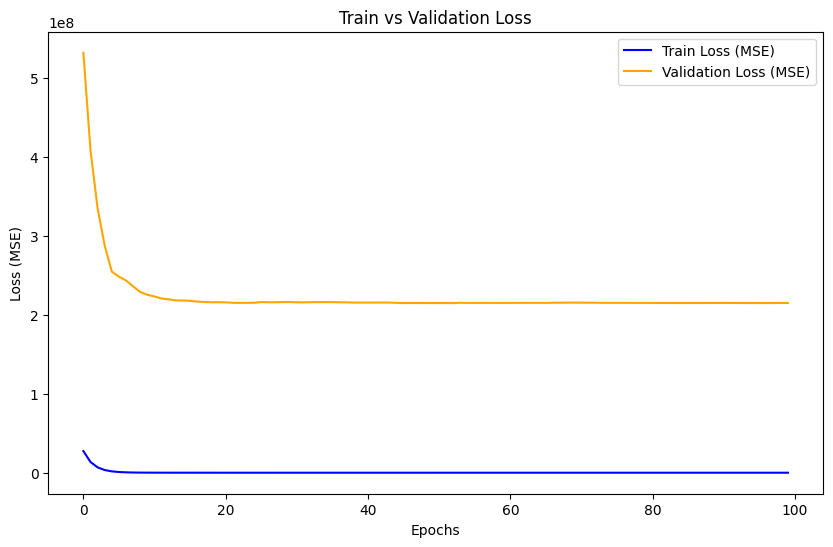

In [12]:
#loss

import matplotlib.pyplot as plt
import xgboost as xgb

# XGBoost 모델 초기화
model = xgb.XGBRegressor(objective='reg:squarederror')  # 손실 함수: Mean Squared Error

# 데이터 차원 변경 -> XGBoost는 2D 형태의 데이터 입력을 필요로 함
x_train = x_train.reshape((x_train.shape[0], -1))  # (samples, features)
x_val = x_val.reshape((x_val.shape[0], -1))  # (samples, features)
x_test = x_test.reshape((x_test.shape[0], -1))  # (samples, features)

# Train과 Validation 데이터 설정
evals = [(x_train, y_train), (x_val, y_val)]

# 모델 훈련
model.fit(
    x_train,
    y_train,
    eval_set=evals,
    verbose=True
)

# 평가 결과 가져오기
evals_result = model.evals_result()

# 에포크 수 가져오기
epochs = len(evals_result['validation_0']['rmse'])  # 전체 훈련 에포크 수
x_axis = range(0, epochs)

# Loss 계산 (Train Loss와 Validation Loss)
train_loss = evals_result['validation_0']['rmse']  # 기본적으로 RMSE로 출력됨
val_loss = evals_result['validation_1']['rmse']

# MSE로 변환 (XGBoost는 RMSE를 저장하므로 이를 MSE로 변환)
train_loss_mse = [loss ** 2 for loss in train_loss]
val_loss_mse = [loss ** 2 for loss in val_loss]

# 손실(Loss) 플롯
plt.figure(figsize=(10, 6))
plt.plot(x_axis, train_loss_mse, label='Train Loss (MSE)', color='blue')
plt.plot(x_axis, val_loss_mse, label='Validation Loss (MSE)', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()


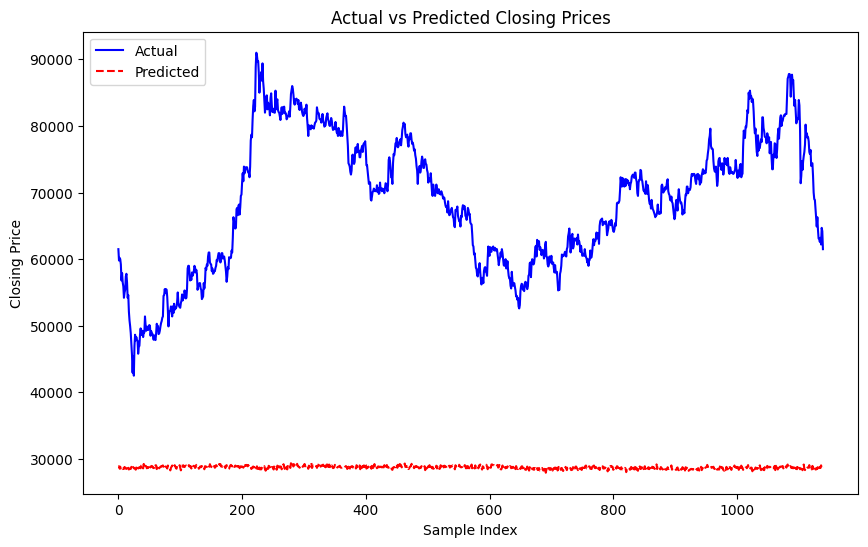

In [13]:
y_pred = model.predict(x_test)

plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual', color='blue')  # y_test는 이미 numpy.ndarray이므로 .values 없이 사용
plt.plot(y_pred, label='Predicted', color='red', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [15]:


y_pred = model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

MAE: 39972.95019702577
MSE: 1697788351.9063692
RMSE: 41204.227354803894
R^2: -15.945350646972656


In [16]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [ ]:
#xx


# XGBoost 모델 정의
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# 하이퍼파라미터 그리드 설정
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'gamma': [0, 0.1, 0.2]
}

# GridSearchCV로 하이퍼파라미터 튜닝
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# 훈련 데이터로 학습
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits


KeyboardInterrupt: 

In [ ]:
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# 하이퍼파라미터 그리드 설정 (범위 축소)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 0.1]
}

# GridSearchCV로 하이퍼파라미터 튜닝 (교차 검증 횟수 3으로 줄이기)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error',
                           verbose=2, n_jobs=-1)

# 훈련 데이터로 학습
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


KeyboardInterrupt: 

In [ ]:
# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# 평가 지표 계산
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

MAE: 0.7983261303253364
MSE: 0.6592719882484773
RMSE: 0.8119556565776713


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import numpy as np

# XGBoost 모델 정의
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# 하이퍼파라미터 랜덤 탐색 범위 설정
param_dist = {
    'learning_rate': np.arange(0.01, 0.2, 0.01),
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'gamma': [0, 0.1, 0.2]
}

# RandomizedSearchCV로 하이퍼파라미터 튜닝
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   n_iter=30, cv=3, scoring='neg_mean_squared_error',
                                   verbose=2, n_jobs=-1, random_state=42)

# 훈련 데이터로 학습
random_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Parameters:", random_search.best_params_)

# 최적 모델로 예측
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.08, 'gamma': 0, 'colsample_bytree': 0.9}
MAE: 0.8222762765774254
MSE: 0.698281934974173
RMSE: 0.835632655521655


In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

MAE: 0.7983261303253364
MSE: 0.6592719882484773
RMSE: 0.8119556565776713


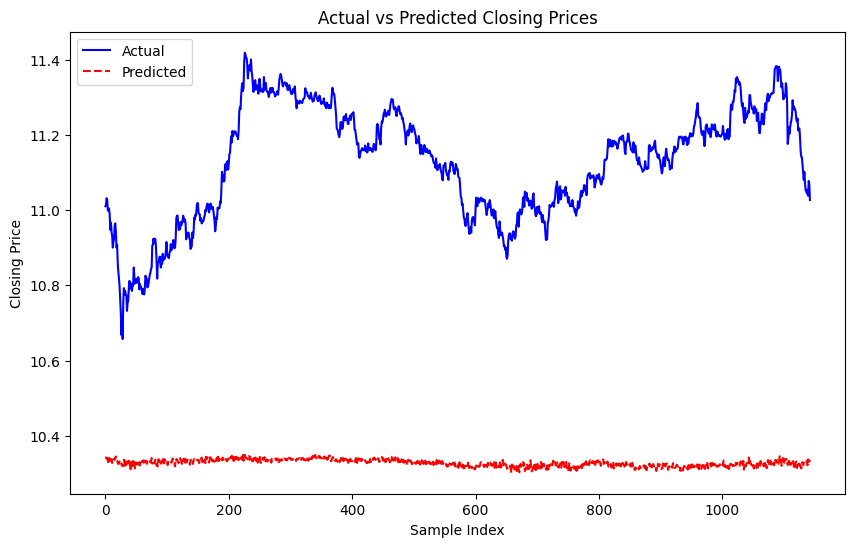

In [ ]:
import matplotlib.pyplot as plt

# 예측 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual', color='blue')  # 실제 값
plt.plot(y_pred, label='Predicted', color='red', linestyle='dashed')  # 예측 값
plt.xlabel('Sample Index')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
#xxx
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import numpy as np

model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

param_grid = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 150, 200, 300],
    'max_depth': [3, 5, 6, 8, 10],
    'min_child_weight': [1, 3, 5, 7, 10],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.7, 0.8, 0.9, 1],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

# GridSearchCV로 하이퍼파라미터 튜닝
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error',
                           verbose=2, n_jobs=-1)

# GridSearchCV로 훈련
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Parameters:", grid_search.best_params_)

# 최적의 모델
best_model = grid_search.best_estimator_

# early_stopping_rounds를 사용하여 훈련
best_model.fit(x_train, y_train,
               eval_set=[(x_train, y_train), (x_val, y_val)],  # 훈련 데이터와 검증 데이터
               early_stopping_rounds=10,  # 성능 개선이 없으면 10 라운드 후에 훈련 중지
               verbose=True)

y_pred = best_model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


Fitting 3 folds for each of 50000 candidates, totalling 150000 fits


KeyboardInterrupt: 

# int

In [17]:
x_train_int, y_train_int = create_sequences(train_int_df.drop(columns=['Close']), train_same_df['Close'], seq_length)
x_val_int, y_val_int = create_sequences(val_int_df.drop(columns=['Close']), val_same_df['Close'], seq_length)
x_test_int, y_test_int = create_sequences(test_int_df.drop(columns=['Close']), test_same_df['Close'], seq_length)

# 데이터 차원 변경 -> XGBoost는 2D 형태의 데이터 입력을 필요, (samples, features) 형태로 변환
x_train_int = x_train_int.reshape((x_train_int.shape[0], -1))  # (배치 크기, 특성 수) 형태로 변환
x_val_int = x_val_int.reshape((x_val_int.shape[0], -1))  # (배치 크기, 특성 수) 형태로 변환
x_test_int = x_test_int.reshape((x_test_int.shape[0], -1))  # (배치 크기, 특성 수) 형태로 변환

[0]	validation_0-rmse:5237.77676	validation_1-rmse:23065.53318
[1]	validation_0-rmse:3686.46435	validation_1-rmse:20303.60754
[2]	validation_0-rmse:2598.99814	validation_1-rmse:18288.46699
[3]	validation_0-rmse:1839.13242	validation_1-rmse:16929.79041
[4]	validation_0-rmse:1308.67737	validation_1-rmse:15939.67389
[5]	validation_0-rmse:940.26131	validation_1-rmse:15499.72754
[6]	validation_0-rmse:685.06397	validation_1-rmse:15166.13171
[7]	validation_0-rmse:511.23249	validation_1-rmse:14935.72280
[8]	validation_0-rmse:393.47008	validation_1-rmse:14695.05384
[9]	validation_0-rmse:315.91557	validation_1-rmse:14606.18413
[10]	validation_0-rmse:264.04970	validation_1-rmse:14557.58755
[11]	validation_0-rmse:231.87395	validation_1-rmse:14516.19476
[12]	validation_0-rmse:210.02290	validation_1-rmse:14515.48913
[13]	validation_0-rmse:194.56526	validation_1-rmse:14508.13229
[14]	validation_0-rmse:184.64050	validation_1-rmse:14491.98215
[15]	validation_0-rmse:176.09316	validation_1-rmse:14489.937

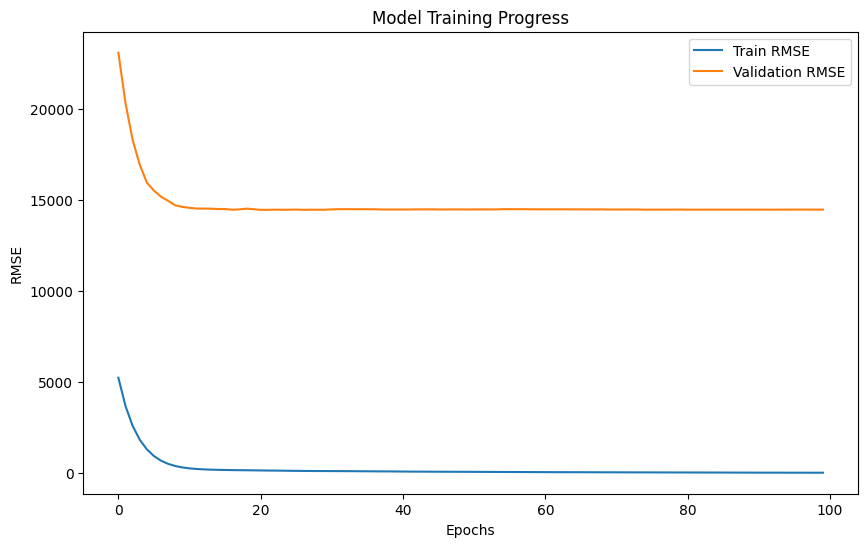

In [18]:
import matplotlib.pyplot as plt
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
evals = [(x_train_int, y_train_int), (x_val_int, y_val_int)]
evals_result = model.fit(x_train_int, y_train_int, eval_set=evals, verbose=True)
evals_result = model.evals_result()

epochs = len(evals_result['validation_0']['rmse'])  # 전체 훈련 에포크 수
x_axis = range(0, epochs)

plt.figure(figsize=(10,6))
plt.plot(x_axis, evals_result['validation_0']['rmse'], label='Train RMSE')
plt.plot(x_axis, evals_result['validation_1']['rmse'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Model Training Progress')
plt.legend()
plt.show()

[0]	validation_0-rmse:5237.77676	validation_1-rmse:23065.53318
[1]	validation_0-rmse:3686.46435	validation_1-rmse:20303.60754
[2]	validation_0-rmse:2598.99814	validation_1-rmse:18288.46699
[3]	validation_0-rmse:1839.13242	validation_1-rmse:16929.79041
[4]	validation_0-rmse:1308.67737	validation_1-rmse:15939.67389
[5]	validation_0-rmse:940.26131	validation_1-rmse:15499.72754
[6]	validation_0-rmse:685.06397	validation_1-rmse:15166.13171
[7]	validation_0-rmse:511.23249	validation_1-rmse:14935.72280
[8]	validation_0-rmse:393.47008	validation_1-rmse:14695.05384
[9]	validation_0-rmse:315.91557	validation_1-rmse:14606.18413
[10]	validation_0-rmse:264.04970	validation_1-rmse:14557.58755
[11]	validation_0-rmse:231.87395	validation_1-rmse:14516.19476
[12]	validation_0-rmse:210.02290	validation_1-rmse:14515.48913
[13]	validation_0-rmse:194.56526	validation_1-rmse:14508.13229
[14]	validation_0-rmse:184.64050	validation_1-rmse:14491.98215
[15]	validation_0-rmse:176.09316	validation_1-rmse:14489.937

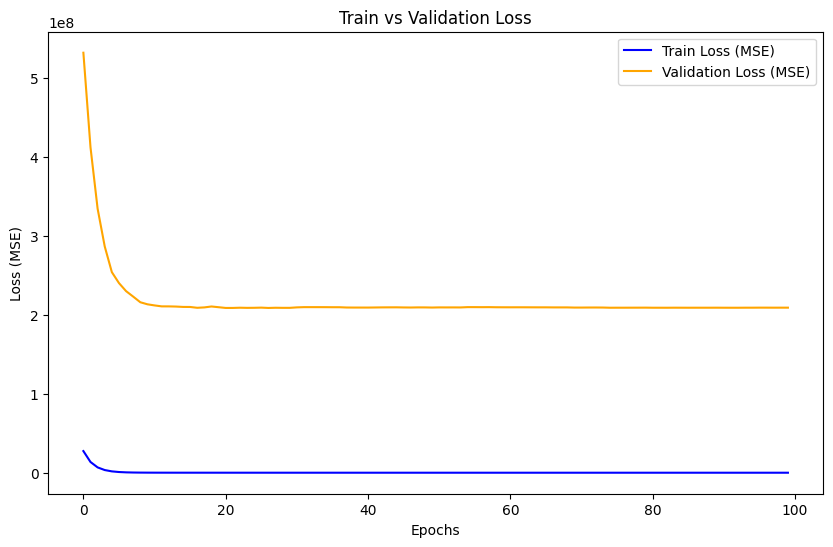

In [19]:
#loss

import matplotlib.pyplot as plt
import xgboost as xgb

# XGBoost 모델 초기화
model = xgb.XGBRegressor(objective='reg:squarederror')  # 손실 함수: Mean Squared Error

# 데이터 차원 변경 -> XGBoost는 2D 형태의 데이터 입력을 필요로 함
x_train_int = x_train_int.reshape((x_train_int.shape[0], -1))  # (samples, features)
x_val_int = x_val_int.reshape((x_val_int.shape[0], -1))  # (samples, features)
x_test_int = x_test_int.reshape((x_test_int.shape[0], -1))  # (samples, features)

# Train과 Validation 데이터 설정
evals = [(x_train_int, y_train_int), (x_val_int, y_val_int)]

# 모델 훈련
model.fit(
    x_train_int,
    y_train_int,
    eval_set=evals,
    verbose=True
)

# 평가 결과 가져오기
evals_result = model.evals_result()

# 에포크 수 가져오기
epochs = len(evals_result['validation_0']['rmse'])  # 전체 훈련 에포크 수
x_axis = range(0, epochs)

# Loss 계산 (Train Loss와 Validation Loss)
train_loss = evals_result['validation_0']['rmse']  # 기본적으로 RMSE로 출력됨
val_loss = evals_result['validation_1']['rmse']

# MSE로 변환 (XGBoost는 RMSE를 저장하므로 이를 MSE로 변환)
train_loss_mse = [loss ** 2 for loss in train_loss]
val_loss_mse = [loss ** 2 for loss in val_loss]

# 손실(Loss) 플롯
plt.figure(figsize=(10, 6))
plt.plot(x_axis, train_loss_mse, label='Train Loss (MSE)', color='blue')
plt.plot(x_axis, val_loss_mse, label='Validation Loss (MSE)', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()


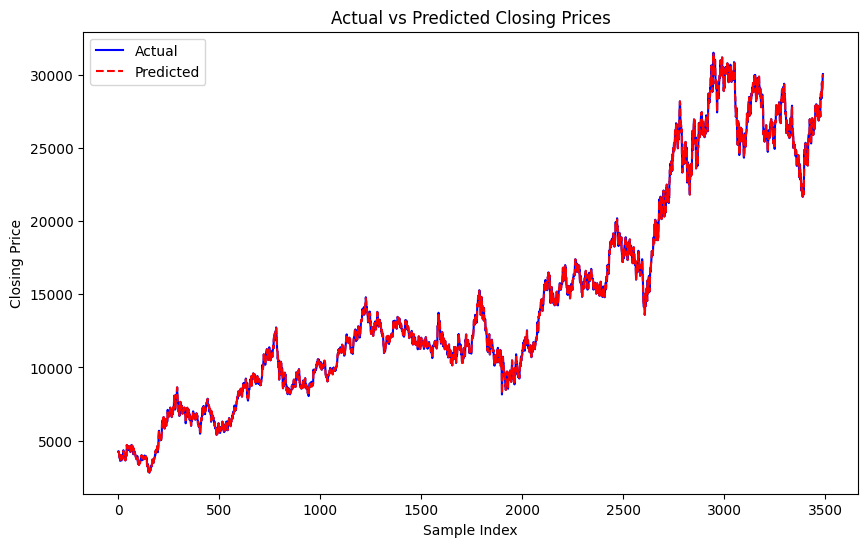

In [20]:
y_pred = model.predict(x_train_int)

plt.figure(figsize=(10,6))
plt.plot(y_train_int, label='Actual', color='blue')  # y_test는 이미 numpy.ndarray이므로 .values 없이 사용
plt.plot(y_pred, label='Predicted', color='red', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

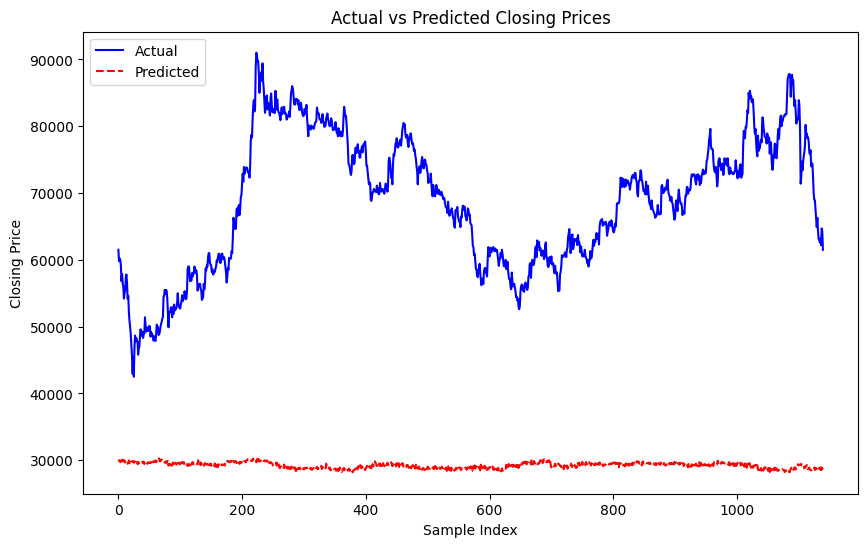

In [21]:
y_pred = model.predict(x_test_int)

plt.figure(figsize=(10,6))
plt.plot(y_test_int, label='Actual', color='blue')  # y_test는 이미 numpy.ndarray이므로 .values 없이 사용
plt.plot(y_pred, label='Predicted', color='red', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(x_val_int)

mae = mean_absolute_error(y_val_int, y_pred)
mse = mean_squared_error(y_val_int, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_val_int, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

MAE: 11587.471637822617
MSE: 209077103.7560151
RMSE: 14459.49873806195
R^2: -1.0171823501586914


In [23]:
int_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# 하이퍼파라미터 그리드 설정 (범위 축소)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 0.1]
}

# GridSearchCV로 하이퍼파라미터 튜닝 (교차 검증 횟수 3으로 줄이기)
grid_search = GridSearchCV(estimator=int_model, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error',
                           verbose=2, n_jobs=-1)

# 훈련 데이터로 학습
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(y_val, label='Actual', color='blue')  # 실제 값
plt.plot(y_pred, label='Predicted', color='red', linestyle='dashed')  # 예측 값
plt.xlabel('Sample Index')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

In [ ]:
# 최적 모델로 예측
int_best_model = grid_search.best_estimator_
y_pred = int_best_model.predict(x_val_int)

# 평가 지표 계산
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_val_int, y_pred)
mse = mean_squared_error(y_val_int, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_val_int, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")



---





---





---



In [24]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# XGBoost 모델 학습 및 평가 함수
def train_and_evaluate_xgb(x_train, y_train, x_val, y_val):
    # XGBoost 데이터 포맷으로 변환
    train_dmatrix = xgb.DMatrix(data=x_train, label=y_train)
    val_dmatrix = xgb.DMatrix(data=x_val, label=y_val)

    # XGBoost 파라미터 설정 (MSE 기반)
    params = {
        'objective': 'reg:squarederror',  # MSE를 기반으로 학습
        'eval_metric': 'rmse',  # 로그에서는 rmse 사용, 하지만 MSE를 계산해 따로 로그로 시각화
        'eta': 0.1,
        'max_depth': 6,
    }

    # 학습
    evals_result = {}
    model = xgb.train(
        params=params,
        dtrain=train_dmatrix,
        num_boost_round=100,
        evals=[(train_dmatrix, 'train'), (val_dmatrix, 'val')],
        early_stopping_rounds=10,
        evals_result=evals_result,
        verbose_eval=False
    )

    # Loss Plot (MSE로 변환하여 시각화)
    train_rmse = np.array(evals_result['train']['rmse'])
    val_rmse = np.array(evals_result['val']['rmse'])
    train_mse = train_rmse ** 2
    val_mse = val_rmse ** 2

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(train_mse)), train_mse, label='Train Loss')
    plt.plot(range(len(val_mse)), val_mse, label='Validation Loss')
    plt.title(f'XGBoost Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model

In [55]:
# MSE, MAE, RMSE, R^2 계산 및 Plot 함수
def evaluate_and_plot(model, x_test, y_test):
    test_dmatrix = xgb.DMatrix(data=x_test)
    y_pred = model.predict(test_dmatrix)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f'Metrics:')
    print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R^2: {r2:.4f}')

    # Plot 실제값 vs 예측값
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual Values', color = 'blue',alpha=0.7)
    plt.plot(y_pred, label='Predicted Values', color = 'red', alpha=0.7)
    plt.title(f'XGBoost validation prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid()
    plt.legend()
    plt.show()

    return mse, mae, rmse, r2



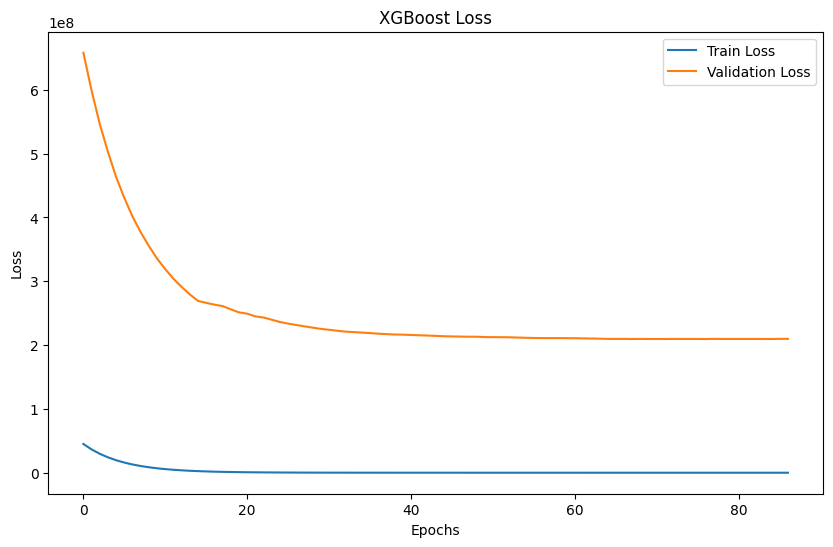

Metrics:
MSE: 209740224.7535, MAE: 11564.2587, RMSE: 14482.4109, R^2: -1.0236


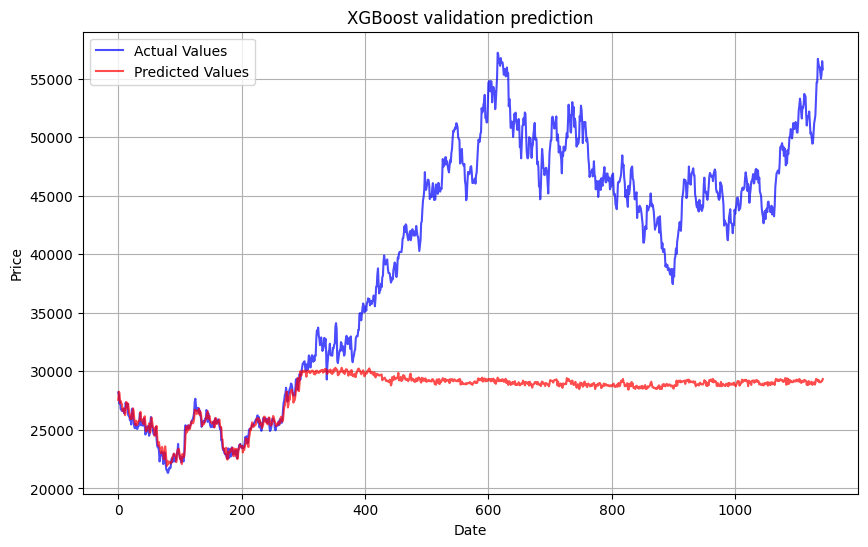

In [56]:
same_model = train_and_evaluate_xgb(x_train, y_train, x_val, y_val)
same_metrics = evaluate_and_plot(same_model, x_val, y_val)

Date range in dataset: 2015-03-19 00:00:00 to 2019-11-15 00:00:00


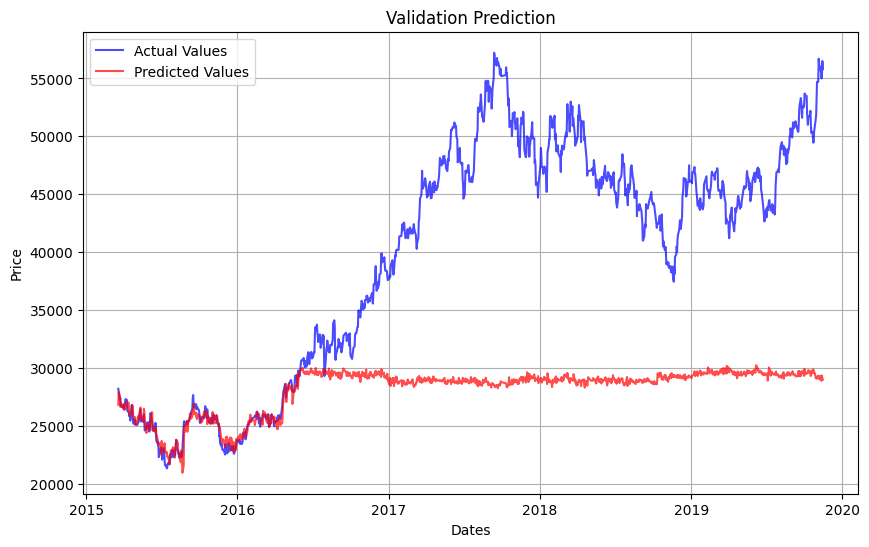

In [36]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

val = np.round(y_val, 4)
pred = np.round(y_pred, 4)

#dates = [datetime.strptime(date, '%Y-%m-%d') for date in same_df[3519:4662].index]
dates = [datetime.strptime(date, '%Y-%m-%d') for date in same_df[3519:3519 + len(pred)].index]

start_date = dates[0]
end_date = dates[-1]
print(f"Date range in dataset: {start_date} to {end_date}")

plt.figure(figsize=(10, 6))
plt.plot(dates, val[:len(pred)], label='Actual Values', color='blue', alpha=0.7)
plt.plot(dates, pred, label='Predicted Values',color='red', alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Validation Prediction')
plt.xlabel('Dates')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


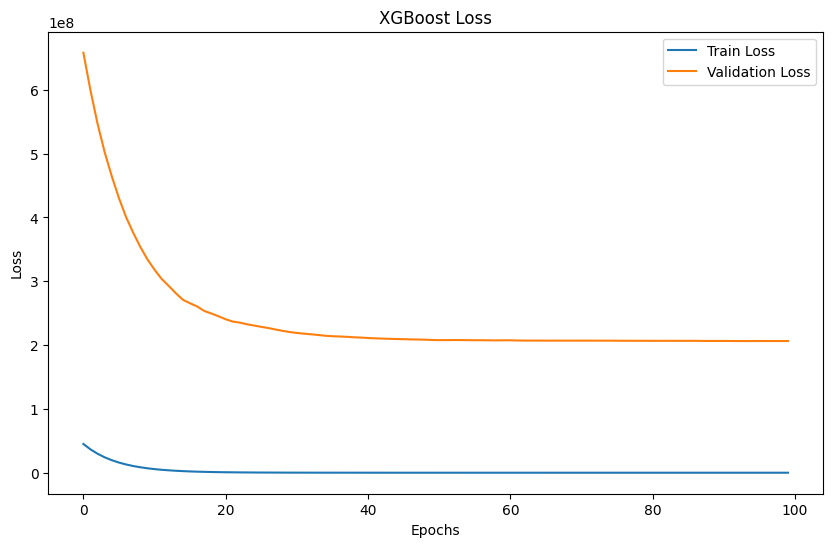

Metrics:
MSE: 206309390.0496, MAE: 11485.6382, RMSE: 14363.4742, R^2: -0.9905


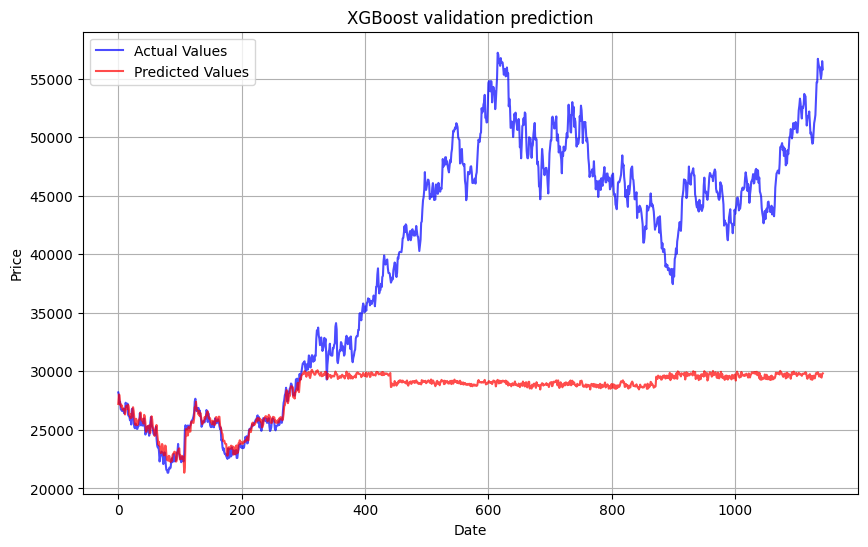

In [28]:
int_model = train_and_evaluate_xgb(x_train_int, y_train_int, x_val_int, y_val_int)
int_metrics = evaluate_and_plot(int_model, x_val_int, y_val_int)

Date range in dataset: 2015-03-19 00:00:00 to 2019-11-15 00:00:00


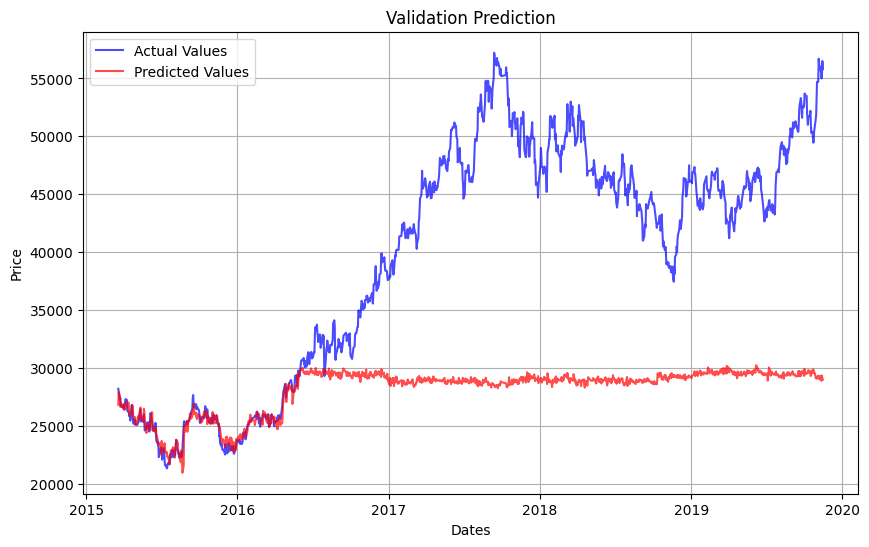

In [38]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

val = np.round(y_val_int, 4)
pred = np.round(y_pred, 4)

#dates = [datetime.strptime(date, '%Y-%m-%d') for date in same_df[3519:4662].index]
dates = [datetime.strptime(date, '%Y-%m-%d') for date in same_df[3519:3519 + len(pred)].index]

start_date = dates[0]
end_date = dates[-1]
print(f"Date range in dataset: {start_date} to {end_date}")

plt.figure(figsize=(10, 6))
plt.plot(dates, val[:len(pred)], label='Actual Values', color='blue', alpha=0.7)
plt.plot(dates, pred, label='Predicted Values',color='red', alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Validation Prediction')
plt.xlabel('Dates')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
print("Same DataFrame Metrics:")
print(f"MSE: {same_metrics[0]:.4f}")
print(f"MAE: {same_metrics[1]:.4f}")
print(f"RMSE: {same_metrics[2]:.4f}")
print(f"R2: {same_metrics[3]:.4f}")

Same DataFrame Metrics:
MSE: 209740224.7535
MAE: 11564.2587
RMSE: 14482.4109
R2: -1.0236


In [40]:
print("\nInt DataFrame Metrics:")
print(f"MSE: {int_metrics[0]:.4f}")
print(f"MAE: {int_metrics[1]:.4f}")
print(f"RMSE: {int_metrics[2]:.4f}")
print(f"R2: {int_metrics[3]:.4f}")


Int DataFrame Metrics:
MSE: 206309390.0496
MAE: 11485.6382
RMSE: 14363.4742
R2: -0.9905


In [32]:
y_val.shape

(1143,)

In [33]:
y_pred.shape

(1143,)

In [34]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# 하이퍼파라미터 범위 설정
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [50, 100, 200]
}

# XGBoost Regressor 초기화
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # MSE 기반 평가
    cv=3,  # 교차 검증
    verbose=1,
    n_jobs=-1  # 병렬 처리
)

# Grid Search 실행
grid_search.fit(x_train, y_train)

# 최적의 파라미터와 점수 출력
print("Best Parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


KeyboardInterrupt: 

In [41]:
from sklearn.model_selection import RandomizedSearchCV

# 하이퍼파라미터 범위 설정
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [50, 100, 150, 200, 300],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}
# XGBoost Regressor 초기화
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    scoring='neg_mean_squared_error',
    n_iter=50,  # 탐색 횟수
    cv=3,  # 교차 검증
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Randomized Search 실행
random_search.fit(x_train, y_train)

# 최적의 파라미터와 점수 출력
print("Best Parameters:", random_search.best_params_)
print("Best MSE:", -random_search.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 1.0}
Best MSE: 26246272.573567912


In [68]:
# same
best_params = random_search.best_params_
optimized_model = xgb.XGBRegressor(**best_params)
optimized_model.fit(x_train, y_train)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = optimized_model.predict(x_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_val, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

MSE: 189063820.2134
MAE: 10947.3063
RMSE: 13750.0480
R2: -0.8241


In [67]:
# int
best_params = random_search.best_params_
optimized_model = xgb.XGBRegressor(**best_params)
optimized_model.fit(x_train_int, y_train_int)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = optimized_model.predict(x_val_int)
mse = mean_squared_error(y_val_int, y_pred)
mae = mean_absolute_error(y_val_int, y_pred)
rmse = mse ** 0.5
# int
best_params = random_search.best_params_
optimized_model = xgb.XGBRegressor(**best_params)
optimized_model.fit(x_train_int, y_train_int)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = optimized_model.predict(x_val_int)
mse = mean_squared_error(y_val_int, y_pred)
mae = mean_absolute_error(y_val_int, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_val_int, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

MSE: 193669670.8977
MAE: 11095.1403
RMSE: 13916.5251
R2: -0.8685


In [44]:
def train_and_evaluate_xgb_tuned(x_train, y_train, x_val, y_val, best_params):
    # XGBoost 데이터 포맷으로 변환
    train_dmatrix = xgb.DMatrix(data=x_train, label=y_train)
    val_dmatrix = xgb.DMatrix(data=x_val, label=y_val)

    # 최적 파라미터로 학습
    evals_result = {}
    model = xgb.train(
        params=best_params,
        dtrain=train_dmatrix,
        num_boost_round=100,
        evals=[(train_dmatrix, 'train'), (val_dmatrix, 'val')],
        early_stopping_rounds=10,
        evals_result=evals_result,
        verbose_eval=False
    )

    # Loss Plot (MSE로 변환하여 시각화)
    train_rmse = np.array(evals_result['train']['rmse'])
    val_rmse = np.array(evals_result['val']['rmse'])
    train_mse = train_rmse ** 2
    val_mse = val_rmse ** 2

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(train_mse)), train_mse, label='Train Loss')
    plt.plot(range(len(val_mse)), val_mse, label='Validation Loss')
    plt.title(f'XGBoost Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model

In [57]:
def evaluate_and_plot_tuned(model, x_val, y_val):
    test_dmatrix = xgb.DMatrix(data=x_val)
    y_pred = model.predict(test_dmatrix)

    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    print(f'Metrics:')
    print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R^2: {r2:.4f}')

    # 로그 변환이 필요 없다면 np.exp 제거
    val = np.round(y_val, 4)
    pred = np.round(y_pred, 4)

    dates = [datetime.strptime(date, '%Y-%m-%d') for date in same_df[3519:4662].index]

    start_date = dates[0]
    end_date = dates[-1]
    print(f"Date range in dataset: {start_date} to {end_date}")

    plt.figure(figsize=(10, 6))
    plt.plot(dates, val, label='Actual Values', color='blue', alpha=0.7)
    plt.plot(dates, pred, label='Predicted Values', color='red', alpha=0.7)

    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.title('Validation Prediction')
    plt.xlabel('Dates')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return mse, mae, rmse, r2



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:43:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


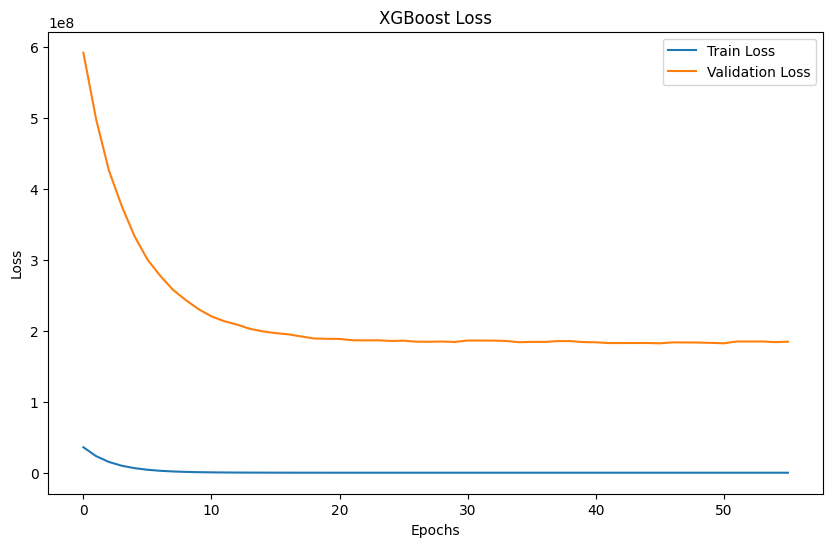

In [58]:
same_model_tuned = train_and_evaluate_xgb_tuned(x_train, y_train, x_val, y_val, best_params)

Metrics:
MSE: 184727880.8915, MAE: 10807.8064, RMSE: 13591.4635, R^2: -0.7823
Date range in dataset: 2015-03-19 00:00:00 to 2019-11-15 00:00:00


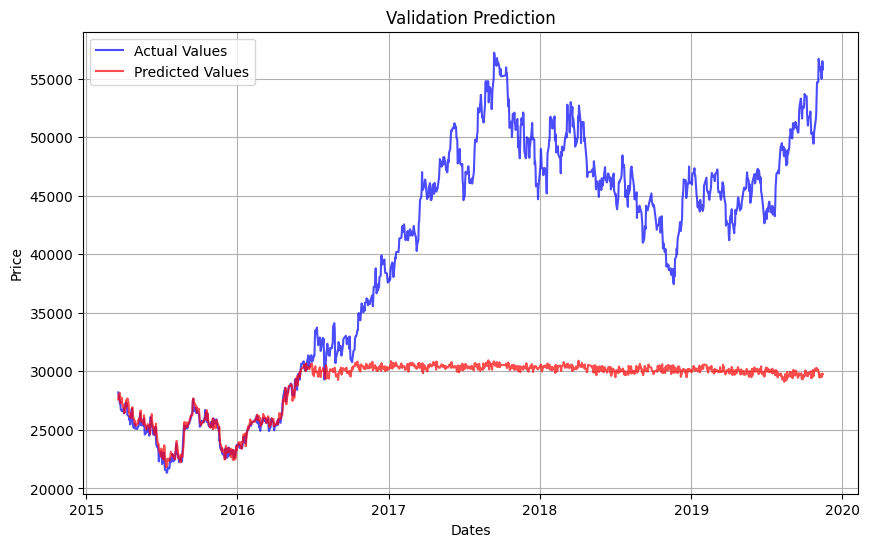

In [59]:
same_metrics_tuned = evaluate_and_plot_tuned(same_model_tuned, x_val, y_val)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:43:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


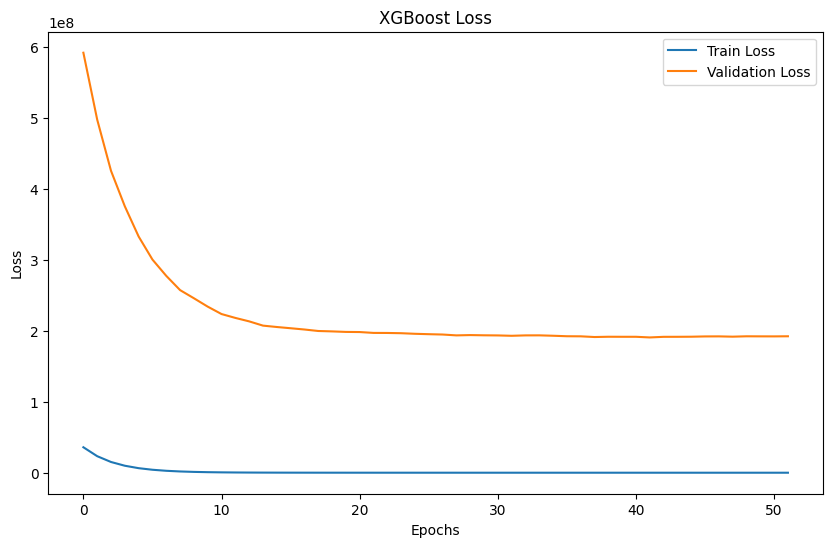

In [60]:
same_model_tuned = train_and_evaluate_xgb_tuned(x_train_int, y_train_int, x_val_int, y_val_int, best_params)

Metrics:
MSE: 192356435.6458, MAE: 11055.3515, RMSE: 13869.2623, R^2: -0.8559
Date range in dataset: 2015-03-19 00:00:00 to 2019-11-15 00:00:00


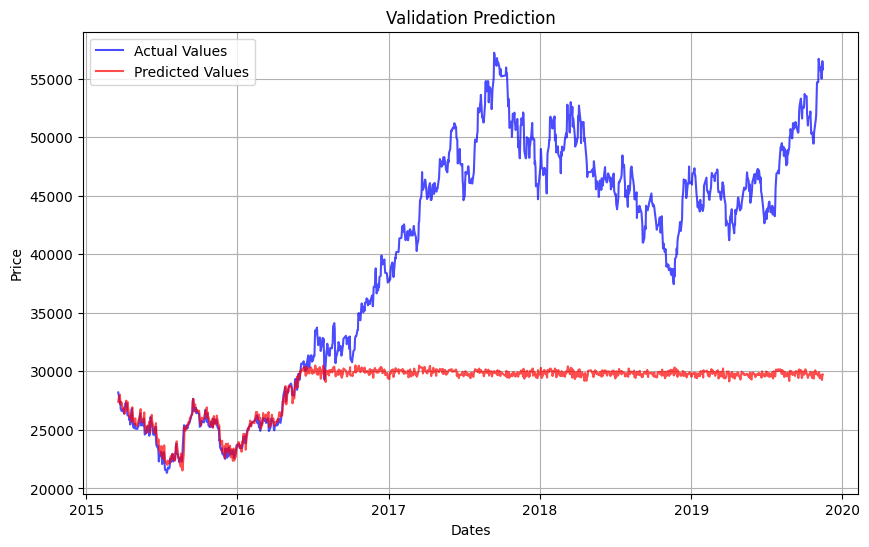

In [61]:
same_metrics_tuned = evaluate_and_plot_tuned(same_model_tuned, x_val_int, y_val_int)

In [50]:
# 모델의 모든 주요 파라미터 출력
params = optimized_model.get_params()

# 깔끔한 출력
print("Model Parameters:\n")
print(f"1. Learning Rate: {params['learning_rate']}")
print(f"2. Max Depth: {params['max_depth']}")
print(f"3. Number of Estimators: {params['n_estimators']}")
print(f"4. Subsample: {params['subsample']}")
print(f"5. Colsample by Tree: {params['colsample_bytree']}")
print(f"6. Gamma (Regularization): {params['gamma']}")
print(f"7. Min Child Weight: {params['min_child_weight']}")
print(f"8. Objective: {params['objective']}")
print(f"9. Booster: {params['booster']}")
print(f"10. Tree Method: {params['tree_method']}")
print(f"11. Scale Pos Weight: {params['scale_pos_weight']}")
print(f"12. Random State: {params['random_state']}")
print(f"13. Verbosity: {params['verbosity']}")

Model Parameters:

1. Learning Rate: 0.2
2. Max Depth: 3
3. Number of Estimators: 150
4. Subsample: 0.7
5. Colsample by Tree: 1.0
6. Gamma (Regularization): 0.2
7. Min Child Weight: 1
8. Objective: reg:squarederror
9. Booster: None
10. Tree Method: None
11. Scale Pos Weight: None
12. Random State: None
13. Verbosity: None


In [45]:
# Booster 객체를 가져오기
booster = optimized_model.get_booster()

# 모델 파라미터 확인
print("Model Parameters:")
print(booster.save_config())

# 트리 구조 출력
print("Model Tree Structure:")
print(booster.get_dump()[0])  # 첫 번째 트리만 확인


Model Parameters:
{"learner":{"generic_param":{"device":"cpu","fail_on_invalid_gpu_id":"0","n_jobs":"0","nthread":"0","random_state":"0","seed":"0","seed_per_iteration":"0","validate_parameters":"1"},"gradient_booster":{"gbtree_model_param":{"num_parallel_tree":"1","num_trees":"300"},"gbtree_train_param":{"process_type":"default","tree_method":"auto","updater":"grow_quantile_histmaker","updater_seq":"grow_quantile_histmaker"},"name":"gbtree","specified_updater":false,"tree_train_param":{"alpha":"0","cache_opt":"1","colsample_bylevel":"1","colsample_bynode":"1","colsample_bytree":"0.600000024","eta":"0.200000003","gamma":"0","grow_policy":"depthwise","interaction_constraints":"","lambda":"1","learning_rate":"0.200000003","max_bin":"256","max_cat_threshold":"64","max_cat_to_onehot":"4","max_delta_step":"0","max_depth":"3","max_leaves":"0","min_child_weight":"1","min_split_loss":"0","monotone_constraints":"()","refresh_leaf":"1","reg_alpha":"0","reg_lambda":"1","sampling_method":"uniform"

<Figure size 4500x1800 with 0 Axes>

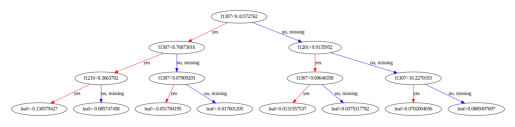


Number of Trees: 300


In [57]:
import matplotlib.pyplot as plt
import xgboost as xgb

# 트리 시각화 (DPI로 화질 개선)
plt.figure(figsize=(15, 6), dpi=300)  # DPI를 300으로 설정
xgb.plot_tree(optimized_model, num_trees=3)  # num_trees=3: 네 번째 트리
plt.show()
print("\nNumber of Trees:", optimized_model.get_booster().num_boosted_rounds())

In [51]:
# 모델의 트리 덤프를 텍스트 형태로 출력
trees_dump = optimized_model.get_booster().get_dump()
for i, tree in enumerate(trees_dump[:10]):  # 상위 2개 트리만 출력
    print(f"Tree {i}:\n{tree}\n")


Tree 0:
0:[f1307<9.53097343] yes=1,no=2,missing=2
	1:[f1307<8.909235] yes=3,no=4,missing=4
		3:[f425<0.211056381] yes=7,no=8,missing=8
			7:leaf=-0.135909587
			8:leaf=-0.237854883
		4:[f1307<9.23785782] yes=9,no=10,missing=10
			9:leaf=-0.0659931526
			10:leaf=-0.015139577
	2:[f1305<9.93207455] yes=5,no=6,missing=6
		5:[f1307<9.7231636] yes=11,no=12,missing=12
			11:leaf=0.0383432731
			12:leaf=0.071724467
		6:[f1307<10.1503477] yes=13,no=14,missing=14
			13:leaf=0.125102594
			14:leaf=0.155470714


Tree 1:
0:[f1307<9.48029137] yes=1,no=2,missing=2
	1:[f1306<8.98844624] yes=3,no=4,missing=4
		3:[f875<0.0693529695] yes=7,no=8,missing=8
			7:leaf=-0.105528429
			8:leaf=-0.187769696
		4:[f1307<9.20230865] yes=9,no=10,missing=10
			9:leaf=-0.0547661893
			10:leaf=-0.0160254817
	2:[f1065<9.99592686] yes=5,no=6,missing=6
		5:[f1307<9.67023087] yes=11,no=12,missing=12
			11:leaf=0.0234298762
			12:leaf=0.052566994
		6:[f1306<10.2094641] yes=13,no=14,missing=14
			13:leaf=0.106471241
			14:le